In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn import metrics

In [2]:
df_leans = pd.read_pickle('data/df_leans.pkl')

In [225]:
df_leans

,id,title,publication,author,date,year,month,url,content,leaning,factual
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,Left-Center,High
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",Left-Center,High
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",Left-Center,High
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",Left-Center,High
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",Left-Center,High
...,...,...,...,...,...,...,...,...,...,...,...
142565,218078,An eavesdropping Uber driver saved his 16-year...,Washington Post,Avi Selk,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Uber driver Keith Avila picked up a p...,Left-Center,High
142566,218079,Plane carrying six people returning from a Cav...,Washington Post,Sarah Larimer,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Crews on Friday continued to search L...,Left-Center,High
142567,218080,After helping a fraction of homeowners expecte...,Washington Post,Renae Merle,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,When the Obama administration announced a...,Left-Center,High
142568,218081,"Yes, this is real: Michigan just banned bannin...",Washington Post,Chelsea Harvey,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,This story has been updated. A new law in...,Left-Center,High


### Headline prediction

In [4]:
df_leans[df_leans.title.isnull()]

,id,title,publication,author,date,year,month,url,content,leaning,factual
64875,96065,NaN,Talking Points Memo,NaN,2016-02-12,2016.0,2.0,https://web.archive.org/web/20160213080712/htt...,Harry Reid tries to drop kick Alan Grayson rig...,Left,Mostly Factual
120637,185332,NaN,Reuters,Daniel Wallis,2016-01-15,2016.0,1.0,http://www.reuters.com/article/us-oregon-milit...,"The occupiers, who took over buildings at the ...",Least Biased,Very High


In [5]:
vectorizer = TfidfVectorizer(max_df = 0.3,
                            min_df = 8,
                            stop_words = 'english',
                            lowercase=True,
                            use_idf = True,
                            smooth_idf=True)


In [6]:
title_corpus = df_leans.title.drop([64875, 120637])
y_title = df_leans.leaning.drop([64875, 120637])

In [7]:
X_title = vectorizer.fit_transform(title_corpus)

# Title train test split

Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_title, y_title, test_size = 0.25, random_state = 5)

In [8]:
nb_model = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)
nb_model.fit(Xt_train, yt_train)
nb_pred = nb_model.predict(Xt_test)
nb_score_f = metrics.f1_score(yt_test,nb_pred, average='weighted')
print(nb_score_f)


0.52300646663325


### Article prediction

In [3]:
from scipy import sparse

In [4]:
X = sparse.load_npz('data/news_sparsematrix.npz')

In [5]:
X

<142570x75804 sparse matrix of type '<class 'numpy.float64'>'
	with 34022160 stored elements in Compressed Sparse Row format>

In [7]:
y = df_leans.leaning.values

In [8]:
# Initial train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

In [14]:
acc_scores_df = pd.DataFrame(index=['MultinomialNB', 'ComplementNB', 'BernoulliNB'], columns = [1, 0.1, 0.01])
f1_scores_df = pd.DataFrame(index=['MultinomialNB', 'ComplementNB', 'BernoulliNB'], columns = [1, 0.1, 0.01])

for alpha in [1, 0.1, 0.01]:
    nb_model = MultinomialNB(alpha=alpha, fit_prior=True, class_prior=None)
    cnb_model = ComplementNB(alpha=alpha, fit_prior=True, class_prior=None)
    bnb_model = BernoulliNB(alpha=alpha, fit_prior=True, class_prior=None)
    
    nb_model.fit(X_train, y_train)
    cnb_model.fit(X_train, y_train)
    bnb_model.fit(X_train, y_train)
    
    nb_pred = nb_model.predict(X_test)
    cnb_pred = cnb_model.predict(X_test)
    bnb_pred = bnb_model.predict(X_test)
    
    nb_score_a = metrics.accuracy_score(y_test, nb_pred)
    cnb_score_a = metrics.accuracy_score(y_test, cnb_pred)
    bnb_score_a = metrics.accuracy_score(y_test, bnb_pred)
    
    nb_score_f = metrics.f1_score(y_test, nb_pred, average='weighted')
    cnb_score_f = metrics.f1_score(y_test, cnb_pred, average='weighted')
    bnb_score_f = metrics.f1_score(y_test, bnb_pred, average='weighted')
    
    acc_scores_df[alpha] = [nb_score_a, cnb_score_a, bnb_score_a]
    f1_scores_df[alpha] = [nb_score_f, cnb_score_f, bnb_score_f]

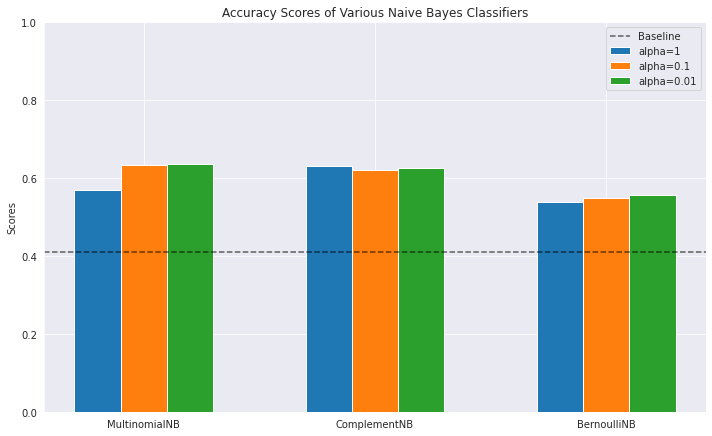

In [15]:
sns.set_style("darkgrid")

labels = acc_scores_df.index
x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width, acc_scores_df.iloc[:,0], width, label = 'alpha=1')
rects2 = ax.bar(x, acc_scores_df.iloc[:,1], width, label = 'alpha=0.1')
rects3 = ax.bar(x + width, acc_scores_df.iloc[:,2], width, label = 'alpha=0.01')

ax.set_ylim((0,1.0))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Scores')
ax.axhline(y=(58380 / 142570), color='black',linestyle = '--',alpha=0.6,label='Baseline')
ax.legend()

plt.tight_layout()
plt.title('Accuracy Scores of Various Naive Bayes Classifiers')

# plt.savefig('img/NBaccscores.png')
plt.show()



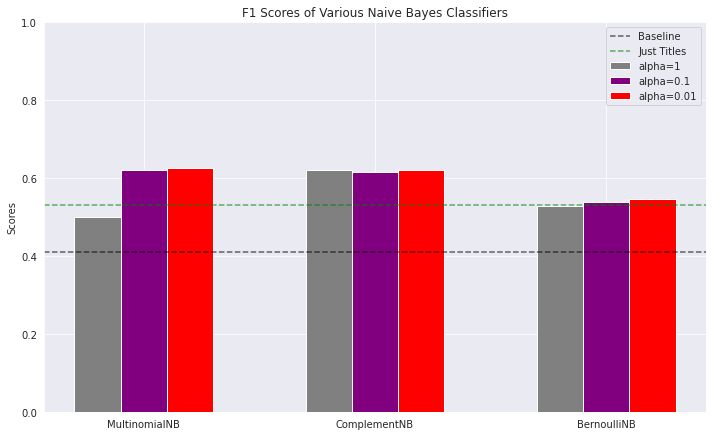

In [231]:
labels = f1_scores_df.index
x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width, f1_scores_df.iloc[:,0], width, label = 'alpha=1', color='grey')
rects2 = ax.bar(x, f1_scores_df.iloc[:,1], width, label = 'alpha=0.1', color = 'purple')
rects3 = ax.bar(x + width, f1_scores_df.iloc[:,2], width, label = 'alpha=0.01', color='red')

ax.set_ylim((0,1.0))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Scores')
ax.axhline(y=(58380 / 142570), color='black',linestyle = '--',alpha=0.6,label='Baseline')
ax.axhline(y=0.53, color='green',linestyle = '--',alpha=0.6,label='Just Titles')
ax.legend()

plt.tight_layout()
plt.title('F1 Scores of Various Naive Bayes Classifiers')

# plt.savefig('img/NBF1scores.png')
plt.show()



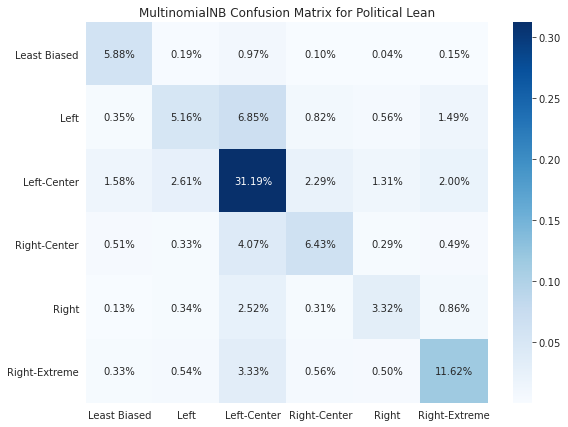

In [17]:
cmlabels = labels=['Least Biased', 'Left', 'Left-Center', 'Right-Center','Right', 
       'Right-Extreme']

cm = confusion_matrix(y_test, nb_pred, labels=cmlabels)


fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=cmlabels, yticklabels=cmlabels)

plt.title('MultinomialNB Confusion Matrix for Political Lean')
# plt.savefig('img/NBconfusionmatrix.png')
plt.show()
